# Outline:
Some EDA  
Data Preprocessing: Column Transformer  
Model Building: Pipeline  
Model selection: Grid Search CV  
Save model: Joblib  
Make predictions on an unseen data point  

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [51]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [52]:
print(">>Dataset shape: ",df.shape)
print(">>null values in the data:")
df.isna().sum()

>>Dataset shape:  (1000, 8)
>>null values in the data:


gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [53]:
scores = df.columns[df.columns.str.contains('score')].tolist()
scores

['math score', 'reading score', 'writing score']

In [54]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


# Visualizing Scores columns

## histograms

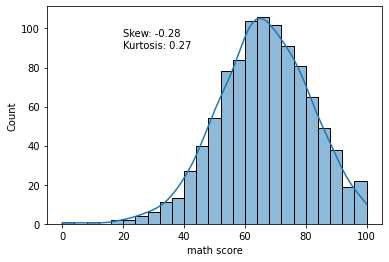

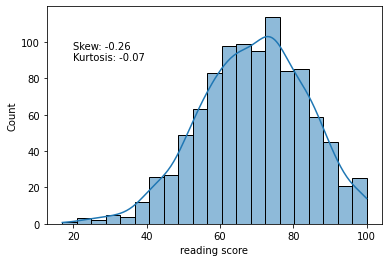

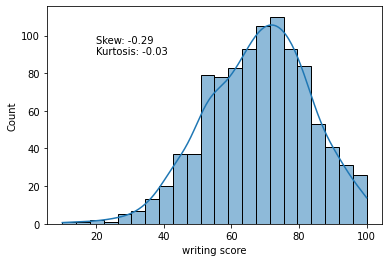

In [55]:
for score in scores:
    sns.histplot(df[score], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[score].skew(),2)}\nKurtosis: {round(df[score].kurt(),2)}")
    plt.show()

## pairplot  
to visualize correlations and distirbutions of all numerical features  

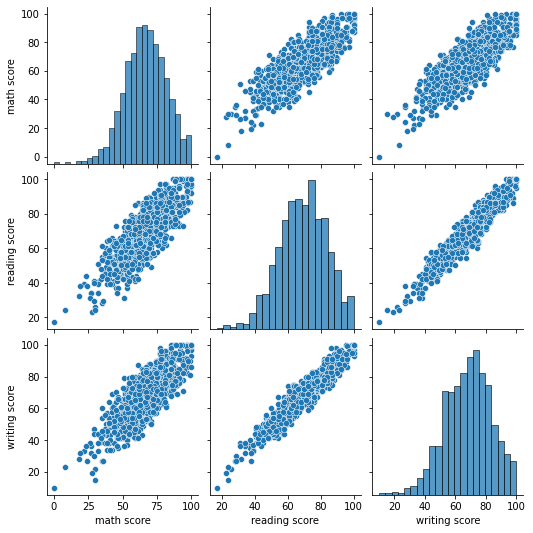

In [56]:
sns.pairplot(data=df)

## Boxed plot for scores vs lunch type
to visulize the median distribution of various groups  

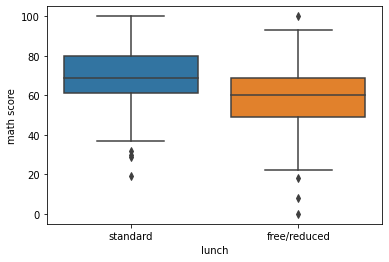

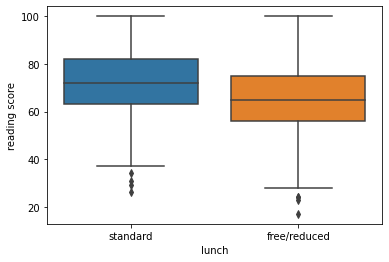

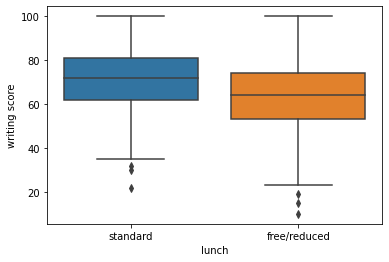

In [57]:
for score in scores:
    sns.boxplot(y=df[score], x=df['lunch'])
    plt.show()

## Boxed plot for scores vs race/ ethnicity group  
to visulize the median distribution of various groups  

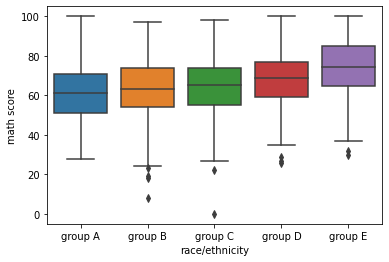

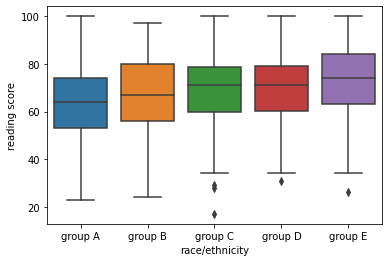

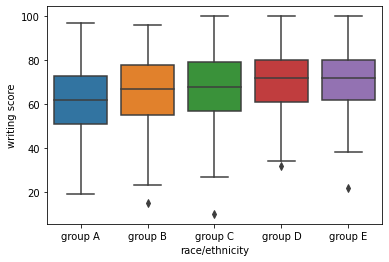

In [58]:
for score in scores:
    sns.boxplot(y=df[score], x=df['race/ethnicity'], order=sorted(df['race/ethnicity'].unique()))
    plt.show()

## Boxed plot for scores vs parental education level  
to visulize the median distribution of various groups 

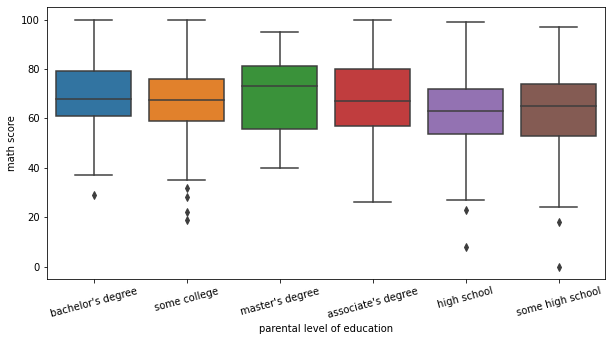

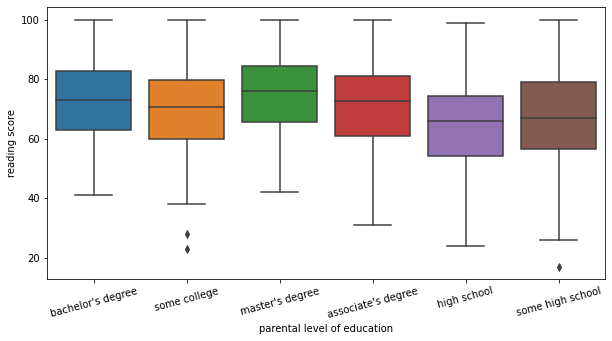

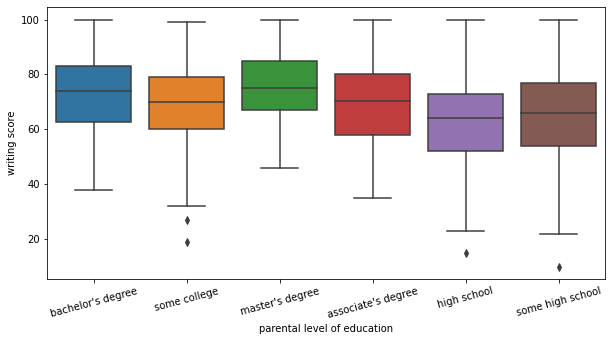

In [59]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['parental level of education'])
    plt.xticks(rotation=15)
    plt.show()

# Target-feature split

In [60]:
X, y = df.drop('writing score', axis=1), df['writing score']

# Ecoding and Data Preprocessing

In [61]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [62]:
#ColumnTransformer with pre-processing steps
ct = ColumnTransformer([
#     ('num', StandardScaler(), ['reading score', 'math score']),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Model tuning and Data fiting

In [63]:
# pipelne with the Data Transformations and model
pipe = Pipeline([
    ('col_trans', ct),
    ('model', RandomForestRegressor(random_state = 0))
])

# parameters of the model
params = {
    'model__n_estimators':[100,200,300],
    'model__max_depth':[5, 9, 13],
    'model__min_samples_split':[2,4,6,8]
}

# CrossValidation
gs = GridSearchCV(pipe, param_grid=params, cv=5, return_train_score=False, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

In [64]:
# fit the data
gs.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'race/ethnicity',
                                                                          'parental '
                                                                          'level '
                                                                          'of '
                                                                          'education',
                                       

In [65]:
# Check the crossvalidation results for the best model
print(">>Validation Results Columns are: ",pd.DataFrame(gs.cv_results_).columns)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)[['params','mean_test_score']]

>>Validation Results Columns are:  Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__max_depth', 'param_model__min_samples_split',
       'param_model__n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


,params,mean_test_score
17,"{'model__max_depth': 9, 'model__min_samples_split': 4, 'model__n_estimators': 300}",-4.033831
20,"{'model__max_depth': 9, 'model__min_samples_split': 6, 'model__n_estimators': 300}",-4.036774
14,"{'model__max_depth': 9, 'model__min_samples_split': 2, 'model__n_estimators': 300}",-4.044065
23,"{'model__max_depth': 9, 'model__min_samples_split': 8, 'model__n_estimators': 300}",-4.045704
16,"{'model__max_depth': 9, 'model__min_samples_split': 4, 'model__n_estimators': 200}",-4.046944
32,"{'model__max_depth': 13, 'model__min_samples_split': 6, 'model__n_estimators': 300}",-4.048050
35,"{'model__max_depth': 13, 'model__min_samples_split': 8, 'model__n_estimators': 300}",-4.048118
19,"{'model__max_depth': 9, 'model__min_samples_split': 6, 'model__n_estimators': 200}",-4.048647
15,"{'model__max_depth': 9, 'model__min_samples_split': 4, 'model__n_estimators': 100}",-4.048679
18,"{'model__max_depth': 9, 'model__min_samples_split': 6, 'model__n_estimators': 100}",-4.049754


In [66]:
# Check for the best parameters and its score
print(">> best estimator: ",gs.best_estimator_)
print(">> best_score: ",gs.best_score_)

>> best estimator:  Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('model',
                 RandomForestRegressor(max_depth=9, min_samples_split=4,
                                       n_estimators=300, random_state=0))])
>> best_score:  -4.033830885300903


# Saving the Model

In [67]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

# Checking the learning curve

In [68]:
a, b, c = learning_curve(gs.best_estimator_, X, y, n_jobs=-1, cv=5)

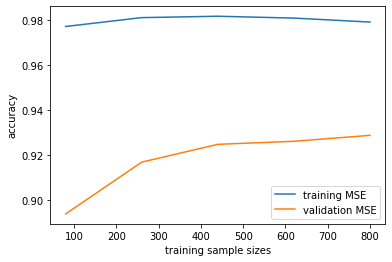

In [69]:
plt.plot(a, b.mean(axis=1), label='training MSE')
plt.plot(a, c.mean(axis=1),  label='validation MSE')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()
#Overfiting

# importing the Saved model

In [70]:
mdl = joblib.load('model.joblib')

# New Predictions  
Making predictions on a new data point NOT seen by the model

In [71]:
# Input features
q = pd.DataFrame([['female', 'group A', 'high school', 'standard', 'completed', 50,87]],
             columns=X.columns)
q

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
0,female,group A,high school,standard,completed,50,87


In [72]:
# predicting the writing score
mdl.predict(q)

array([82.85096862])